# Suave demo notebook: Tophat and spline bases on a periodic box

Hello! In this notebook we'll show you how to use suave, an implementation of the Continuous-Function Estimator, to estimate the 2-point correlation function (2pcf) with a method that produces, well, continuous correlation functions.

In [1]:
import os
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 8),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)
plt.ion()

import Corrfunc
from Corrfunc.io import read_lognormal_catalog
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.theory.DD import DD
from Corrfunc.theory.xi import xi
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi
from Corrfunc.utils import trr_analytic
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.bases import spline_bases

%load_ext autoreload
%autoreload 2

Check suave version:

In [2]:
print(Corrfunc.__file__)
print(Corrfunc.__version__)

/Users/ksf/miniconda3/lib/python3.7/site-packages/Corrfunc/__init__.py
0.0.4


## Load in data

We'll demonstrate with a low-density lognormal simulation box, which we've included with the code. We'll show here the box with 3e-4 ($h^{-1}$Mpc)$^{-3}$, but if you're only running with a single thread, you will want to run this notebook with the 1e-4 ($h^{-1}$Mpc)$^{-3}$ box for speed. (The code is extremely parallel, so when you're running for real, you'll definitely want to bump up the number of threads.)

In [3]:
x, y, z = read_lognormal_catalog(n='2e-4')
boxsize = 750.0
nd = len(x)
print("Number of data points:",nd)

Number of data points: 85827


We'll also want a random catalog that's larger than our data; for speed we'll use a factor of 2, but you'll probably want an even larger one.

In [4]:
nr = 2*nd
x_rand = np.random.uniform(0, boxsize, nr)
y_rand = np.random.uniform(0, boxsize, nr)
z_rand = np.random.uniform(0, boxsize, nr)
print("Number of random points:",nr)

Number of random points: 171654


## Standard correlation function estimation

Let's first compute the regular correlation function. We'll need some radial bins. We'll also need to tell Corrfunc that we're working with a periodic box, and the number of parallel threads. Then we can go ahead and compute the real-space correlation function xi(r) from the pair counts, DD(r) (documentation here: https://corrfunc.readthedocs.io/en/master/api/Corrfunc.theory.html)

In [5]:
rmin = 40.0
rmax = 150.0
nbins = 22
r_edges = np.linspace(rmin, rmax, nbins+1)
r_avg = 0.5*(r_edges[1:]+r_edges[:-1])

periodic = True
nthreads = 1

In [6]:
dd_res = DD(1, nthreads, r_edges, x, y, z, boxsize=boxsize, periodic=periodic)
dr_res = DD(0, nthreads, r_edges, x, y, z, X2=x_rand, Y2=y_rand, Z2=z_rand, boxsize=boxsize, periodic=periodic)
rr_res = DD(1, nthreads, r_edges, x_rand, y_rand, z_rand, boxsize=boxsize, periodic=periodic)

We can use these pair counts to compute the Landy-Szalay 2pcf estimator (Landy & Szalay 1993), with the Corrfunc routine `convert_3d_counts_to_cf`. (Note that if you use weights, you need to multiply by the 'weightavg' column.)

Let's unpack the pair counts from the Corrfunc results object, and plot the resulting correlation function: 

In [7]:
dd = np.array([x['npairs'] for x in dd_res], dtype=float)
dr = np.array([x['npairs'] for x in dr_res], dtype=float)
rr = np.array([x['npairs'] for x in rr_res], dtype=float)
xi_ls = convert_3d_counts_to_cf(nd, nd, nr, nr, dd, dr, dr, rr)

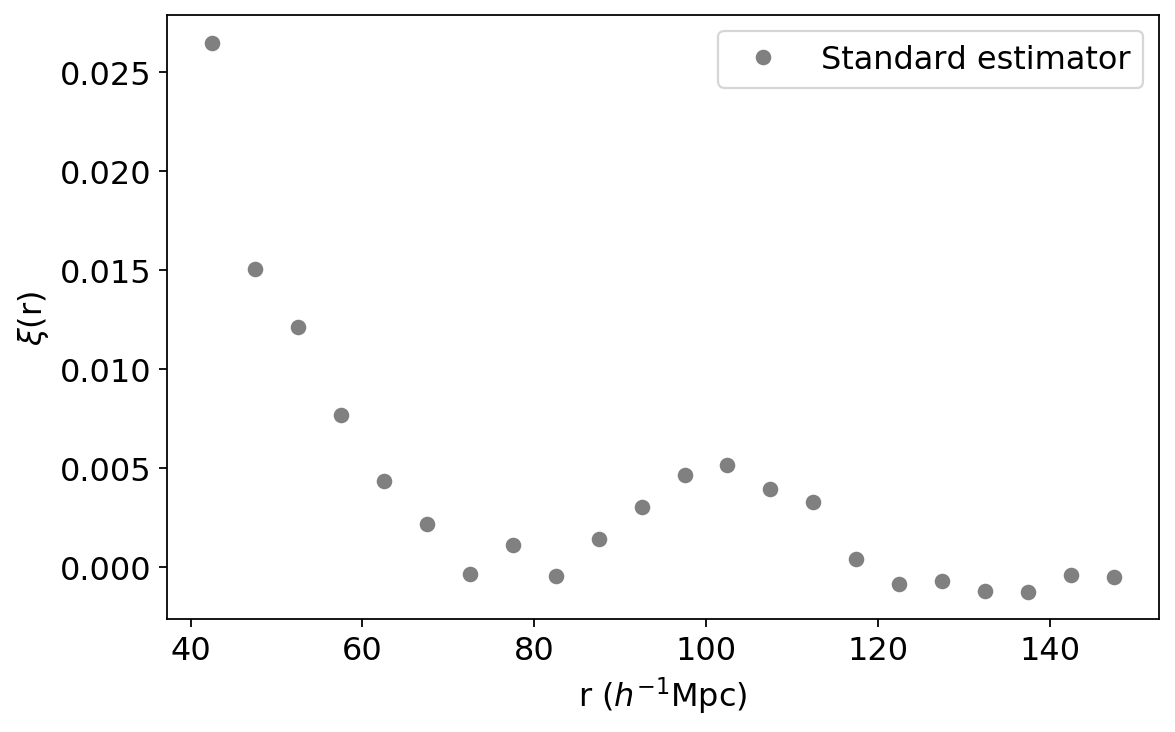

In [8]:
plt.figure(figsize=(8,5))
plt.plot(r_avg, xi_ls, marker='o', ls='None', color='grey', label='Standard estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

Great, we can even see the baryon acoustic feauture at ~100 $h^{-1}$Mpc!

## Suave with a tophat basis

Now we'll use the continuous-function estimator to compute the same correlation function, but in a continuous representation. First we'll use a tophat basis, to achieve the equivalent (but more correct!) result.

We need to give the name of the basis as 'proj_type'. We also need to choose the number of components, 'ncomponents'. In this case, we want the components to be a tophat for each bin, so this will just be 'nbins'. 

In [9]:
proj_type = 'tophat'
ncomponents = nbins

Currently the continuous-function estimator is only implemented in DD(s,mu) ('DDsmu'), the redshift-space correlation function which divides the transverse direction s from the line-of-sight direction mu. But we can simply set the number of mu bins to 1, and mumax to 1 (the max of cosine), to achieve the equivalent of DD in real space.

In [10]:
nmubins = 1
mumax = 1.0

Then we just need to give Corrfunc all this info, and unpack the continuous results! The first returned object is still the regular Corrfunc results object (we could have just used this in our above demo of the standard result).

In [11]:
dd_res, dd_proj, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, 
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type, ncomponents=ncomponents)

In [12]:
dr_res, dr_proj, _ = DDsmu(0, nthreads, r_edges, mumax, nmubins, x, y, z, X2=x_rand, Y2=y_rand, Z2=z_rand,
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type, ncomponents=ncomponents)

In [13]:
rr_res, rr_proj, trr_proj = DDsmu(1, nthreads, r_edges, mumax, nmubins, x_rand, y_rand, z_rand,
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type, ncomponents=ncomponents)

We can now compute the amplitudes of the correlation function from these continuous pair counts. The compute_amps function uses the Landy-Szalay formulation of the estimator, but adapted for continuous bases. (Note that you have to pass some values twice, as this is flexible enough to translate to cross-correlations between two datasets and two random catalogs.)

In [14]:
amps = compute_amps(ncomponents, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, trr_proj)

With these amplitudes, we can evaluate our correlation function at any set of radial separations! Let's make a fine-grained array and evaluate. We need to pass 'ncomponents' and 'proj_type'. Because we will be evaluating our tophat function at the new separations, we also need to give it the original bins.

In [15]:
r_fine = np.linspace(rmin, rmax, 2000)

In [16]:
xi_proj = evaluate_xi(amps, r_fine, proj_type, rbins=r_edges)

Let's check out the results, compared with the standard estimator!

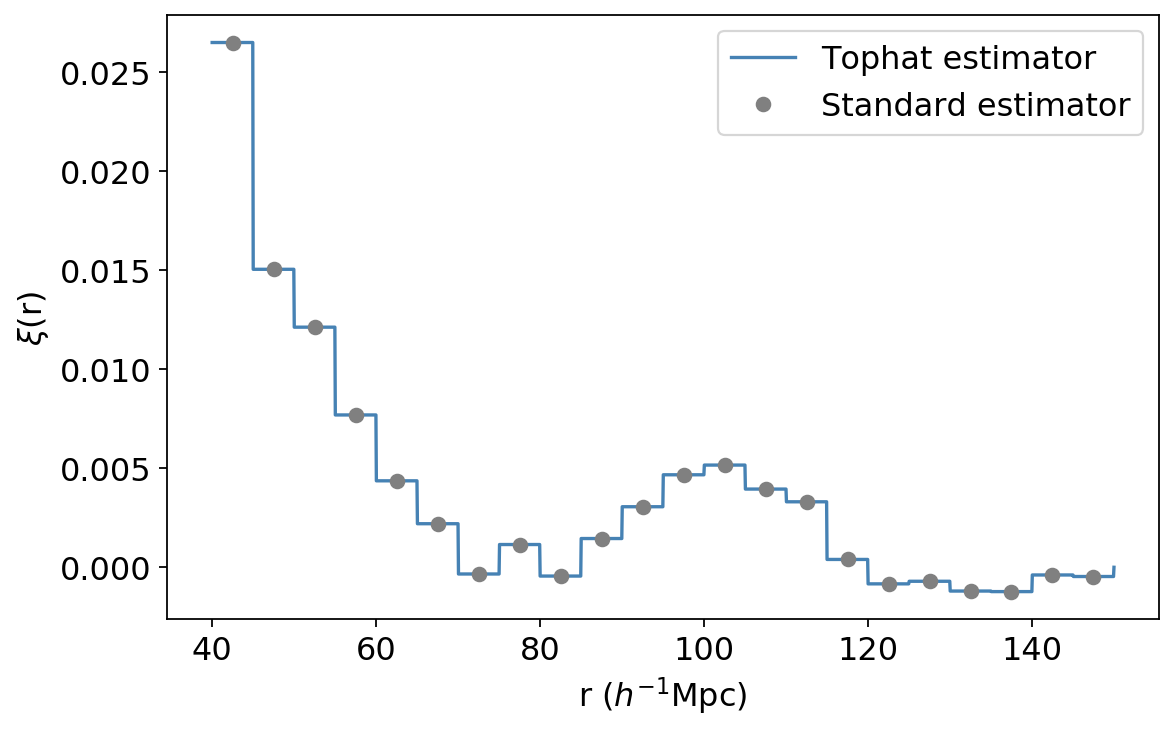

In [17]:
plt.figure(figsize=(8,5))
plt.plot(r_fine, xi_proj, color='steelblue', label='Tophat estimator')
plt.plot(r_avg, xi_ls, marker='o', ls='None', color='grey', label='Standard estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

We can see that we're getting "the same" result, but continously, with the hard bin edges made clear.

## Analytically computing the random term

Because we're working with a periodic box, we don't actually need a random catalog. We can analytically compute the RR term, as well as the QQ matrix.

We'll need the volume of the box, and the same info about our basis function as before:

In [18]:
volume = boxsize**3
rr_ana, trr_ana = trr_analytic(rmin, rmax, nd, volume, ncomponents, proj_type, rbins=r_edges)

We also don't need to use the Landy-Szalay estimator (we don't have a DR term!). To get the amplitudes we can just use the naive estimator, $\frac{\text{DD}}{\text{RR}}-1$. In our formulation, the RR term in the demoninator becomes the inverse QQ term, so we have QQ$^{-1}$ $\cdot$ (DD-RR). 

In [19]:
numerator = dd_proj - rr_ana
amps_ana = np.linalg.solve(trr_ana, numerator) # Use linalg.solve instead of actually computing inverse!

Now we can go ahead and evaluate the correlation function at our fine separations.

In [20]:
xi_ana = evaluate_xi(amps_ana, r_fine, proj_type, rbins=r_edges)

We'll compare this to computing the analytic correlation function with standard Corrfunc:

In [21]:
xi_res = Corrfunc.theory.xi(boxsize, nthreads, r_edges, x, y, z)
xi_theory = np.array([x['xi'] for x in xi_res], dtype=float)

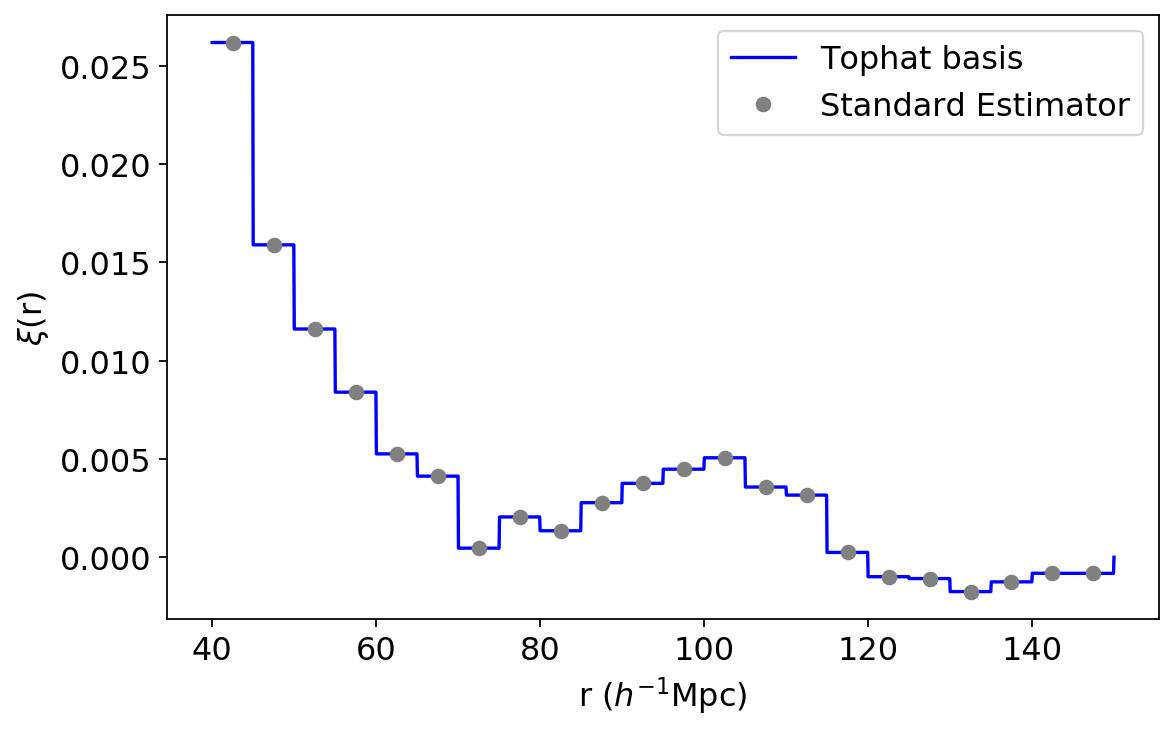

In [22]:
plt.figure(figsize=(8,5))
plt.plot(r_fine, xi_ana, color='blue', label='Tophat basis')
plt.plot(r_avg, xi_theory, marker='o', ls='None', color='grey', label='Standard Estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

Once again, the standard and continuous correlation functions line up exactly. The correlation function looks smoother, as we didn't have to deal with a non-exact random catalog to estimate the window function.

## Suave with a cubic spline basis

Now we can make things more interesting! Let's choose a cubic spline basis. Luckily, this capability comes with the continuous-function version of Corrfunc!

We need to choose the parameters for our spline. Here, we'll choose a cubic spline. If we used a linear spline, we'd get a piecewise function; if we used a zeroth-order spline, we'd recover our tophat bases from above.

We'll take the min and max of the same separation values we used, and choose half the number of components as our previous bins (these will be related to the 'knots' in the spline). We'll also need the number of radial bins at which to evaluate our functions; the code will interpolate between these.

Then we'll write our basis to a file. For any set of basis functions that is read from a file, 'proj_type' must be set to 'general_r'.

In [23]:
proj_type = 'generalr'
kwargs = {'order': 3} # 3: cubic spline
projfn = 'quadratic_spline.dat'
ncomponents = int(nbins/2)
bases = spline_bases(rmin, rmax, projfn, ncomponents, ncont=1000, **kwargs)
print(bases.shape)

(1000, 12)


Let's check out the basis functions (the first column is the r-values):

Text(0.5, 0, 'r ($h^{-1}$Mpc)')

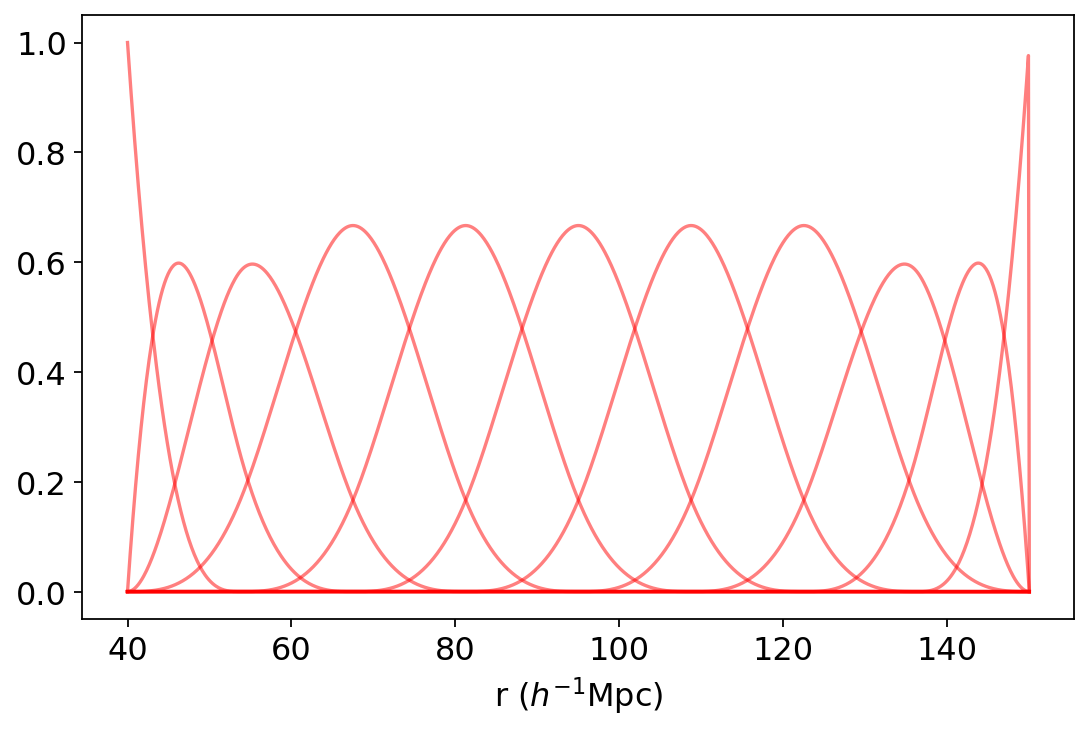

In [24]:
r = bases[:,0]
plt.figure(figsize=(8,5))
for i in range(1, len(bases[0])):
    plt.plot(r, bases[:,i], color='red', alpha=0.5)
plt.xlabel(r'r ($h^{-1}$Mpc)')

The bases on the ends are different so that they have the same normalization.

We'll use the analytic version of the estimator, making sure to pass the basis file:

In [25]:
dd_res_spline, dd_spline, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z, 
                           boxsize=boxsize, periodic=periodic, proj_type=proj_type, ncomponents=ncomponents, projfn=projfn)

In [26]:
volume = boxsize**3
rr_ana_spline, trr_ana_spline = trr_analytic(rmin, rmax, nd, volume, ncomponents, proj_type, rbins=r_edges, projfn=projfn)

numerator = dd_spline - rr_ana_spline
amps_ana_spline = np.linalg.solve(trr_ana_spline, numerator) # Use linalg.solve instead of actually computing inverse!

xi_ana_spline = evaluate_xi(amps_ana_spline, r_fine, proj_type, rbins=r_edges, projfn=projfn)

Let's compare the results:

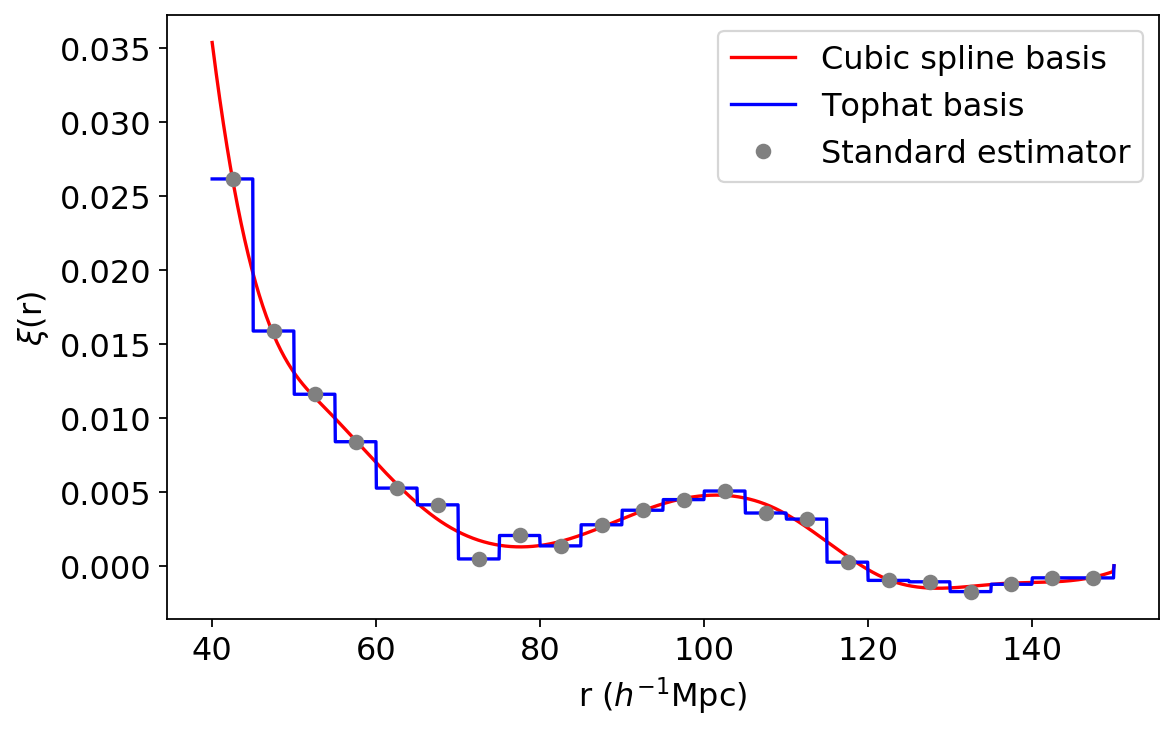

In [27]:
plt.figure(figsize=(8,5))
plt.plot(r_fine, xi_ana_spline, color='red', label='Cubic spline basis')
plt.plot(r_fine, xi_ana, color='blue', label='Tophat basis')
plt.plot(r_avg, xi_theory, marker='o', ls='None', color='grey', label='Standard estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

We can see that the spline basis function produced a completely smooth correlation function; no hard-edged bins! It also captured that baryon acoustic feature (which we expect to be a smooth peak).

This basis function is a bit noisy and likely has some non-physical features - but so does the tophat / standard basis! In the next notebook, we'll use a physically motivated basis function.

Finally, remember to clean up the basis function file:

In [28]:
os.remove(projfn)

The below ipython magic line will convert this notebook to a regular old python script.

In [29]:
#!jupyter nbconvert --to script example_theory.ipynb